#### Exercise 1: Non-Parametric Estimation

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

from keras.datasets import mnist

In [13]:
# Load the dataset and process the data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

pca = PCA(n_components=1)
train = np.column_stack((pca.fit_transform(train_X.reshape(-1, 28*28)).astype(np.float32), train_y))
test = np.column_stack((pca.fit_transform(test_X.reshape(-1, 28*28)).astype(np.float32), test_y))

In [14]:
# Split dataset into C=0 and C=1
data0 = train[train[:, 1] == 0]
data1 = train[train[:, 1] == 1]
test0 = test[test[:, 1] == 0]
test1 = test[test[:, 1] == 1]

# Removing the redundant '0' and '1' labels
data0 = np.delete(data0[np.in1d(data0[:, 1], 0)], 1, axis=1)
data1 = np.delete(data1[np.in1d(data1[:, 1], 1)], 1, axis=1)
test0 = np.delete(test0[np.in1d(test0[:, 1], 0)], 1, axis=1)
test1 = np.delete(test1[np.in1d(test1[:, 1], 1)], 1, axis=1)

data0.shape, data1.shape, test0.shape, test1.shape

((5923, 1), (6742, 1), (980, 1), (1135, 1))

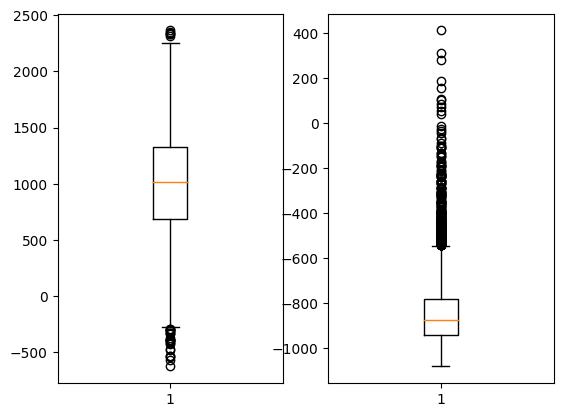

In [15]:
# Scatterplot to visualize classes
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].boxplot(data0)
ax[1].boxplot(data1)
plt.show()

#### Part 1: Histogram-based Estimation

In [16]:
# Converts the data into bin midpoints. Ex. [1, 2, 3, 4] --> [1.5, 1.5, 3.5, 3.5] for 2 bins
ceil_to_nearest = lambda vect, nearest: np.ceil(max(vect) / nearest)*nearest
floor_to_nearest = lambda vect, nearest: np.floor(min(vect) / nearest)*nearest

def compute_bin_edges(x, bin_width):
    min_edge = np.floor(min(x) / bin_width)*bin_width
    max_edge = np.ceil(max(x) / bin_width)*bin_width
    n_bins = int((np.abs(max_edge) + np.abs(min_edge)) / bin_width)
    bin_edges = [int(min_edge + bin_width * bins) for bins in range(n_bins)]
    return np.array(bin_edges), n_bins

def histofy(x, bin_width):
    bin_edges, n_bins = compute_bin_edges(x, bin_width)
    return np.hstack([[(bin_edges[i]+bin_edges[i+1])/2] * x[np.where((bin_edges[i] < x) & (x <= bin_edges[i+1]))].shape[0] for i in range(bin_edges.shape[0]-1)]), n_bins

c01, c01_bins = histofy(data0, 1)
c010, c010_bins = histofy(data0, 10)
c0100, c0100_bins = histofy(data0, 100)
c11, c11_bins = histofy(data1, 1)
c110, c110_bins = histofy(data1, 10)
c1100, c1100_bins = histofy(data1, 100)

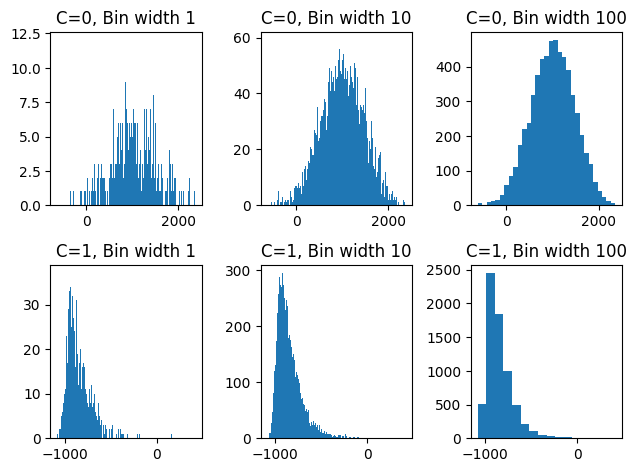

In [17]:
# Display histograms 
fig, ((ax01, ax02, ax03), (ax11, ax12, ax13)) = plt.subplots(2,3)

ax01.hist(data0, bins=c01_bins)
ax01.set_title("C=0, Bin width 1")

ax02.hist(data0, bins=c010_bins)
ax02.set_title("C=0, Bin width 10")

ax03.hist(data0, bins=c0100_bins)
ax03.set_title("C=0, Bin width 100")

ax11.hist(data1, bins=c11_bins)
ax11.set_title("C=1, Bin width 1")

ax12.hist(data1, bins=c110_bins)
ax12.set_title("C=1, Bin width 10")

ax13.hist(data1, bins=c1100_bins)
ax13.set_title("C=1, Bin width 100")

fig.tight_layout(pad=1)

**Which region size seems to be the best for estimating the probabilities? Explain.**

Due to the large range, the bin width of 100 appears best suited to estimation. The bin widths of 1 and 10 look to be largely overfitting while the larger bin width of 100 would generalize better to new data as indicated by the 'smoother' and more visible distribution

Aside from accuracy, the larger bins are also more readable and easier to use as estimators compared to the smaller bins

#### Part 2: Histogram Estimation Accuracy (via ML Classifier)

In [18]:
# Get parameters for each distribution (assume normal distribution)
def compute_stats(x, y):
    m0 = sum(x) / len(x)
    m1 = sum(y) / len(y)
    v0 = sum([(xi - m0)**2 for xi in x]) / len(x)
    v1 = sum([(yi - m1)**2 for yi in y]) / len(y)
    return m0, m1, v0, v1

In [19]:
# Train a classifier
def ml_normal_classifier(x, stats):
    m0, m1, v0, v1 = stats
    p0 = (1/np.sqrt(2*np.pi*v0))*np.exp(-(x-m0)**2/(2*v0))
    p1 = (1/np.sqrt(2*np.pi*v1))*np.exp(-(x-m1)**2/(2*v1))
    return 0 if p0 >= p1 else 1

In [20]:
# Compute accuracy
def accuracies(d0, d1, binw):
    stats = compute_stats(d0, d1)
    acc0 = 1-sum([ml_normal_classifier(i, stats) for i in data0])/data0.shape[0]
    acc1 = sum([ml_normal_classifier(i, stats) for i in data1])/data1.shape[0]
    tacc0 = 1-sum([ml_normal_classifier(i, stats) for i in test0])/test0.shape[0]
    tacc1 = sum([ml_normal_classifier(i, stats) for i in test1])/test1.shape[0]

    print("Bin width ", binw)
    print("Training Accuracy for C=0: ", round(acc0, 8))
    print("Training Accuracy for C=1: ", round(acc1, 8))
    print("Testing Accuracy for C=0: ", round(tacc0, 8))
    print("Testing Accuracy for C=1: ", round(tacc1, 8))
    print()

In [21]:
# Output accuracies for each class and bin width
accuracies(c01, c11, 1)
accuracies(c010, c110, 10)
accuracies(c0100, c1100, 100)

Bin width  1
Training Accuracy for C=0:  0.99729867
Training Accuracy for C=1:  0.98650252
Testing Accuracy for C=0:  0.99897959
Testing Accuracy for C=1:  0.98942731

Bin width  10
Training Accuracy for C=0:  0.99729867
Training Accuracy for C=1:  0.98650252
Testing Accuracy for C=0:  0.99897959
Testing Accuracy for C=1:  0.98942731

Bin width  100
Training Accuracy for C=0:  0.99729867
Training Accuracy for C=1:  0.98679917
Testing Accuracy for C=0:  0.99897959
Testing Accuracy for C=1:  0.98942731



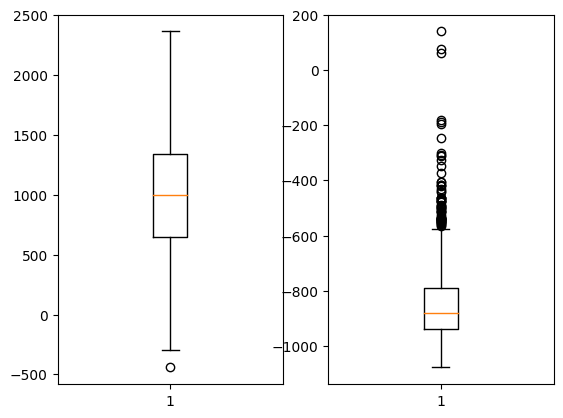

In [22]:
# Scatterplot to visualize test data
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].boxplot(test0)
ax[1].boxplot(test1)
plt.show()

**Which region size seems to be the best in terms of the test error?**

By examining the above accuracies, the best region size is 100. It either has or ties for the highest correct predictions in all tests. If the class distributions were closer to one another, the region size of 100 would still likely perform better as it better generalizes to the data without the issue of overfitting due to lack of data in certain bins

By inspecting the boxplots of the 2 classes and histograms, it can be observed that the 2 classes are well separated, which makes it easy to accurately classify data - hence why all the classifers scored roughly the same accuracies

#### Part 3: Gaussian Kernel-based Density Estimation ($\sigma=20$)

In [23]:
scaler = 20**2

# Fits normal distribution to each point then sums using the given point and normalizes with scaler
def kernel_estimator(datapoint, x):
    return sum([(1/np.sqrt(2*np.pi*scaler))*np.exp(-((datapoint-mean)/scaler)**2/(2*scaler)) for mean in x]) / (len(x)*scaler)

def kernel_classifier(datapoint, x, y):
    p0 = kernel_estimator(datapoint, x)
    p1 = kernel_estimator(datapoint, y)
    return 0 if p0 > p1 else 1

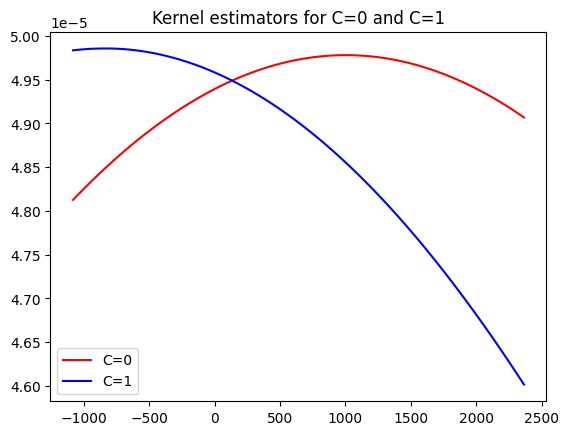

In [34]:
# Plot the 2 culminative distributions obtained from aggregating each kernel function
t = np.linspace(min(min(data0), min(data1)), max(max(data0), max(data1)), 100)
a = kernel_estimator(t, data0)
b = kernel_estimator(t, data1)

plt.plot(t, a, 'r', label='C=0')
plt.plot(t, b, 'b', label='C=1')
plt.legend()
plt.title('Kernel estimators for C=0 and C=1')
plt.show()

In [51]:
# Run Kernel estimator on MNIST dataset to compute accuracy

# Expected runtime: 5.5 minutes
tacc0 = 1-sum([kernel_classifier(i, data0, data1) for i in test0])/test0.shape[0]
print("Testing Accuracy for C=0: ", round(tacc0, 8))

# Expected runtime: 6.5 minutes (total 12 minutes)
tacc1 = sum([kernel_classifier(i, data0, data1) for i in test1])/test1.shape[0]
print("Testing Accuracy for C=1: ", round(tacc1, 8))

Testing Accuracy for C=0:  0.9755102
Testing Accuracy for C=1:  0.99911894


The testing accuracies are about:

* C=0: 0.9755102
* C=1: 0.99911894

#### Part 4: Histogram v. Kernel Estimators

In [54]:
# Calculate overall accuracy by taking weighted sum

# Histogram estimator, bin width 100
histogram_acc = (0.99897959 * test0.shape[0] + 0.98942731 * test1.shape[0]) / (test0.shape[0]+test1.shape[0])
kernel_acc = (0.9755102 * test0.shape[0] + 0.99911894 * test1.shape[0]) / (test0.shape[0]+test1.shape[0])

print("Histogram accuracy (bin_width=100): ", histogram_acc)
print("Kernel accuracy: ", kernel_acc)

print("Histogram is better by ", histogram_acc-kernel_acc)

Histogram accuracy (bin_width=100):  0.9938534255555556
Kernel accuracy:  0.9881796656737589
Histogram is better by  0.005673759881796636


**Which of the two approaches (histogram or kernel) for probability estimations best represent your
data and produce the lowest error? Explain.**

Based on overall test accuracy, the histogram estimator with bin width 100 wins by $\Delta \approx0.00567$

However, based on individual accuracy for each class, the kernel estimator is better at estimating $C=1$ with a 99.9% accuracy versus 98.9% by the histogram accuracy while losing at $C=0$ classification

It is difficult to conclude that the histogram estimator is better than the kernel estimator due to the tiny error. However, their basis is very similar - the histogram estimator behaves identically to the kernel density estimator as bin width approaches 0 (rather than a histogram, it'll be like a normal distribution). With this logic, because the histogram with bin width 100 outperforms the smaller bin widths, I infer that the smaller bin widths and kernel density estimation both slightly overfit on the training data which causes minor issues when classifying the testing data

#### Part 5: Parametric v. Non-Parametric Estimators

In [64]:
# ML Classifier:

# Compute stats
m0 = sum(data0) / len(data0)
m1 = sum(data1) / len(data1)
v0 = sum([(xi - m0)**2 for xi in data0]) / len(data0)
v1 = sum([(xi - m0)**2 for xi in data1]) / len(data1)

# Compute test accuracy
def ml_classifier(datapoint):
    p0 = (1/np.sqrt(2*np.pi*v0))*np.exp(-(datapoint-m0)**2/(2*v0))
    p1 = (1/np.sqrt(2*np.pi*v1))*np.exp(-(datapoint-m1)**2/(2*v1))
    return 0 if p0 >= p1 else 1

# Output accuracies
tacc0 = 1-sum([ml_classifier(i) for i in test0])/test0.shape[0]
print("Testing Accuracy for C=0: ", round(tacc0, 8))

tacc1 = sum([ml_classifier(i) for i in test1])/test1.shape[0]
print("Testing Accuracy for C=1: ", round(tacc1, 8))

print("Overall Accuracy: ", round((tacc0 * test0.shape[0] + tacc1 * test1.shape[0]) / (test0.shape[0]+test1.shape[0]), 8))

Testing Accuracy for C=0:  0.95510204
Testing Accuracy for C=1:  1.0
Overall Accuracy:  0.97919622


**What if you used a parametric estimation method instead? Do you think non-parametric approaches are better than the parametric approaches for density estimation? Explain**

A quick comparison against the ML Gaussian classifier reveals the non-parametric methods used in this report are marginally better than the parametric counterpart

However, the use-cases depend on the data distribution:

* **Parametric estimators** assume a distribution; they perform well when the assumed distribution closely matches the actual distribution (so in this example, the true distribution is close to normal based on the high accuracy)
* **Non-Parametric estimators** do not assume a distribution; they perform better when the actual distribution is more complex (ex. bimodal distributions)

For this analysis, the boxplots show the class distributions are close to normal so both methods work well - as evidenced by the high accuracies throughout all the estimators